In [1]:
import scipy
import random
from tqdm import tqdm
from scipy import optimize
import numpy as np
import pandas as pd
from tqdm import tqdm
import pandas_ta as ta
import yfinance as yf
from time import time
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [11]:
df = pd.read_pickle('~/.../s&p_5Y_hist.pkl')
symbols = sorted([el[0] for el in list(df.columns)[::7]])
df = df[[(ticker, 'Close') for ticker in symbols]]
df = df.interpolate()
df_lr = deepcopy(df.iloc[1:])
df_lr.columns = pd.MultiIndex.from_tuples([(c[0], 'Log_Return') for c in df.columns])
df_lr.iloc[0:] = np.log(df.values[1:]) - np.log(df.values[:-1])
df_lr[pd.isna(df_lr)] = 0
df_lr

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,...,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return,Log_Return
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-22,-0.000195,-0.010523,-0.009164,0.002995,-0.007631,0.003619,-0.006899,0.000000,0.000901,-0.001338,...,-0.012794,0.001413,-0.011792,-0.002563,-0.001657,-0.023474,-0.002307,-0.011020,-0.003347,-0.001685
2017-02-23,0.002529,-0.004761,-0.012351,-0.004239,0.009408,0.002952,-0.000941,0.008627,0.002207,-0.005371,...,-0.009651,0.010768,0.010448,0.001763,-0.015245,-0.005309,-0.004458,0.047495,0.001786,0.003740
2017-02-24,0.005232,0.003897,-0.002476,0.000952,0.002419,0.005986,0.002136,0.006149,0.007727,0.004031,...,0.001810,0.009039,-0.008596,0.005430,0.007965,0.003037,0.004629,0.033256,-0.006042,0.005584
2017-02-27,-0.001547,0.000864,-0.002482,0.001974,0.002092,-0.004677,0.006806,-0.004828,-0.005199,-0.004452,...,0.015830,-0.000693,0.005657,-0.009602,0.021684,-0.006542,0.000342,-0.005935,0.012492,-0.000929
2017-02-28,-0.006993,0.000863,-0.002105,0.000438,-0.006126,-0.002401,0.000254,-0.008394,-0.002365,-0.003711,...,0.006678,0.009194,-0.002701,0.021161,-0.017102,-0.003057,0.001026,-0.018351,-0.004666,-0.009707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-14,-0.014611,-0.010274,0.005993,0.001422,0.006947,-0.000428,-0.015002,-0.021832,-0.009309,0.000084,...,0.001631,-0.008398,-0.015453,-0.007999,0.000224,-0.005504,0.006690,-0.035297,-0.011815,-0.012345
2022-02-15,0.005164,0.077789,-0.007519,0.022889,0.012233,0.009231,0.047965,0.009726,0.010007,0.011515,...,0.044612,-0.004226,-0.012614,0.053989,0.019636,0.013093,0.043079,0.019783,0.026592,0.006748


In [12]:
lambda_ = 1
tau = .999
d = df_lr.shape[1]
idx = 800
s_idx = idx
lambda_, tau, d, idx

(1, 0.999, 506, 800)

In [18]:
# Ridge Regression to initialise matrices
X_t = df_lr.iloc[:idx].values
Y_t = df_lr.iloc[1:idx+1].values
THETA_t = (np.linalg.inv((X_t.T@X_t) + tau*np.eye(d))@X_t.T@Y_t)
Y_hat_t = X_t@THETA_t
PHI_t = np.linalg.inv((Y_t.T@Y_t) + tau*np.eye(d))@Y_t.T@Y_t
y_hat_t = THETA_t @ X_t[-1:None].T
y_pred_t = PHI_t @ y_hat_t

# Outside the loop
P_tm1 = np.eye(d+1)/lambda_
THETA_tm1 = THETA_t
Q_tm1 = np.eye(d)/lambda_
PHI_tm1 = PHI_t

In [ ]:
# Algorithm 3 - Curds & Whey
pbar = tqdm(total=(df_lr.shape[0]-1)-idx)
df_pred_lr = pd.DataFrame(index=df_lr.index[idx+1:], columns=df_lr.columns)
ct = 0
while idx < df_lr.shape[0]-1:
    x_tm1 = np.concatenate((np.ones((1,1)), df_lr.iloc[idx-1].values.reshape(d, 1)))
    x_t = np.concatenate((np.ones((1,1)), df_lr.iloc[idx].values.reshape(d, 1)))

    y_tm1 = df_lr.iloc[idx-1].values.reshape(d, 1)
    y_t = df_lr.iloc[idx].values.reshape(d, 1)
    
    r_t = float(1 + (x_tm1.T@P_tm1@x_tm1)/tau)
    k_t = (P_tm1@x_tm1)/(r_t*tau)
    THETA_t = THETA_tm1 + k_t[1:]@(y_t - THETA_tm1@x_tm1[1:]).T
    P_t = P_tm1/tau - (k_t@k_t.T)*r_t
    P_t = P_t*tau
    y_hat_t = THETA_t@x_t[1:]
    s_t = float(1+(y_tm1.T@Q_tm1@y_tm1)/tau)
    m_t = (Q_tm1@y_tm1)/(s_t*tau)
    PHI_t = PHI_tm1 + m_t@(y_hat_t - PHI_tm1@y_tm1).T
    Q_t = Q_tm1/tau - (m_t@m_t.T)*s_t
    Q_t = Q_t*tau
    y_pred_t = PHI_t@y_hat_t # Forecast vector
    df_pred_lr.iloc[ct] = y_pred_t.reshape(d)

    #### DO SOMETHING WITH FORECAST
    # variable updates
    P_tm1 = P_t
    THETA_tm1 = THETA_t
    Q_tm1 = Q_t
    PHI_tm1 = PHI_t
    idx += 1
    ct += 1
    pbar.update(1)



 68%|██████▊   | 311/458 [00:07<00:03, 44.98it/s]

TMO


<AxesSubplot:xlabel='Date'>


100%|██████████| 458/458 [00:26<00:00, 43.43it/s]

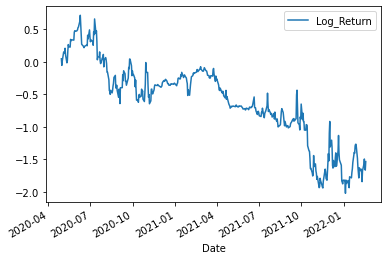

In [24]:
ticker = random.choice(symbols)
print(ticker)
np.cumsum(df_pred_lr[ticker]).plot()

TMO


<AxesSubplot:xlabel='Date'>

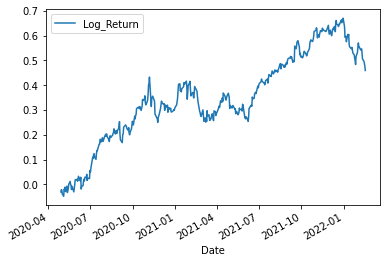

In [25]:
print(ticker)
np.cumsum(df_lr[ticker].iloc[s_idx:-1]).plot()

(array([ 3.,  3.,  2.,  4.,  5.,  8., 14., 24., 25., 25., 27., 41., 40.,
        38., 44., 30., 37., 32., 19., 22., 15., 10.,  6., 10.,  8.,  2.,
         4.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([-0.28506386, -0.25936258, -0.2336613 , -0.20796003, -0.18225875,
        -0.15655747, -0.13085619, -0.10515492, -0.07945364, -0.05375236,
        -0.02805109, -0.00234981,  0.02335147,  0.04905275,  0.07475402,
         0.1004553 ,  0.12615658,  0.15185785,  0.17755913,  0.20326041,
         0.22896169,  0.25466296,  0.28036424,  0.30606552,  0.33176679,
         0.35746807,  0.38316935,  0.40887063,  0.4345719 ,  0.46027318,
         0.48597446,  0.51167573,  0.53737701,  0.56307829,  0.58877957,
         0.61448084,  0.64018212,  0.6658834 ,  0.69158467,  0.71728595,
         0.74298723,  0.76868851,  0.79438978,  0.82009106,  0.84579234,
         0.87149361,  0.89719489,  0.92289617,  0.94859745,

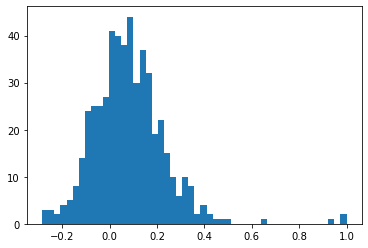

In [26]:
plt.hist(P_t.sum(0), bins=50)

(array([ 3.,  3.,  2.,  4.,  5.,  8., 14., 24., 25., 25., 27., 41., 40.,
        38., 44., 30., 37., 32., 19., 22., 15., 10.,  6., 10.,  8.,  2.,
         4.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([-0.28506386, -0.25936258, -0.2336613 , -0.20796003, -0.18225875,
        -0.15655747, -0.13085619, -0.10515492, -0.07945364, -0.05375236,
        -0.02805109, -0.00234981,  0.02335147,  0.04905275,  0.07475402,
         0.1004553 ,  0.12615658,  0.15185785,  0.17755913,  0.20326041,
         0.22896169,  0.25466296,  0.28036424,  0.30606552,  0.33176679,
         0.35746807,  0.38316935,  0.40887063,  0.4345719 ,  0.46027318,
         0.48597446,  0.51167573,  0.53737701,  0.56307829,  0.58877957,
         0.61448084,  0.64018212,  0.6658834 ,  0.69158467,  0.71728595,
         0.74298723,  0.76868851,  0.79438978,  0.82009106,  0.84579234,
         0.87149361,  0.89719489,  0.92289617,  0.94859745,

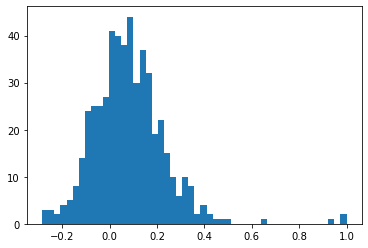

In [27]:
plt.hist(P_t.sum(0), bins=50)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   3.,   1.,   2.,   9.,  16.,  47.,
        116., 246.,  65.]),
 array([0.00231041, 0.042218  , 0.08212558, 0.12203316, 0.16194075,
        0.20184833, 0.24175591, 0.2816635 , 0.32157108, 0.36147866,
        0.40138625, 0.44129383, 0.48120142, 0.521109  , 0.56101658,
        0.60092417, 0.64083175, 0.68073933, 0.72064692, 0.7605545 ,
        0.80046208, 0.84036967, 0.88027725, 0.92018483, 0.96009242,
        1.        ]),
 <BarContainer object of 25 artists>)

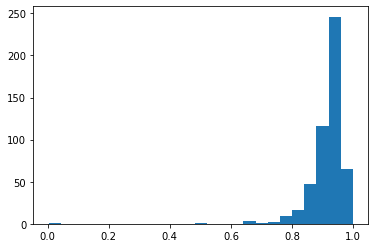

In [28]:
plt.hist(np.diag(P_t), bins=25)

<AxesSubplot:xlabel='Date'>

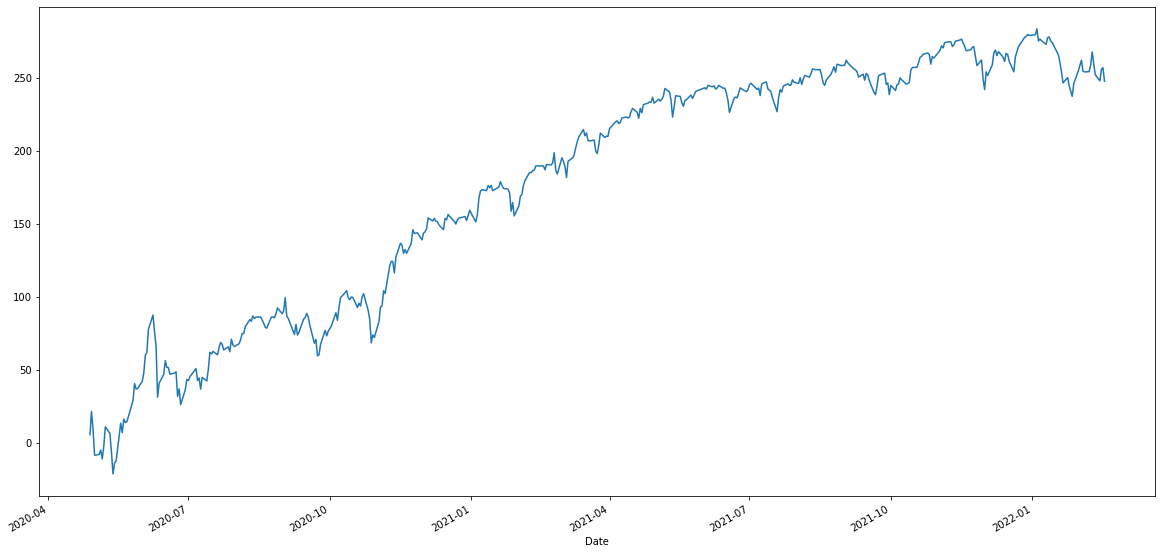

In [30]:
np.cumsum(df_lr.iloc[s_idx:-1].sum(1)).plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

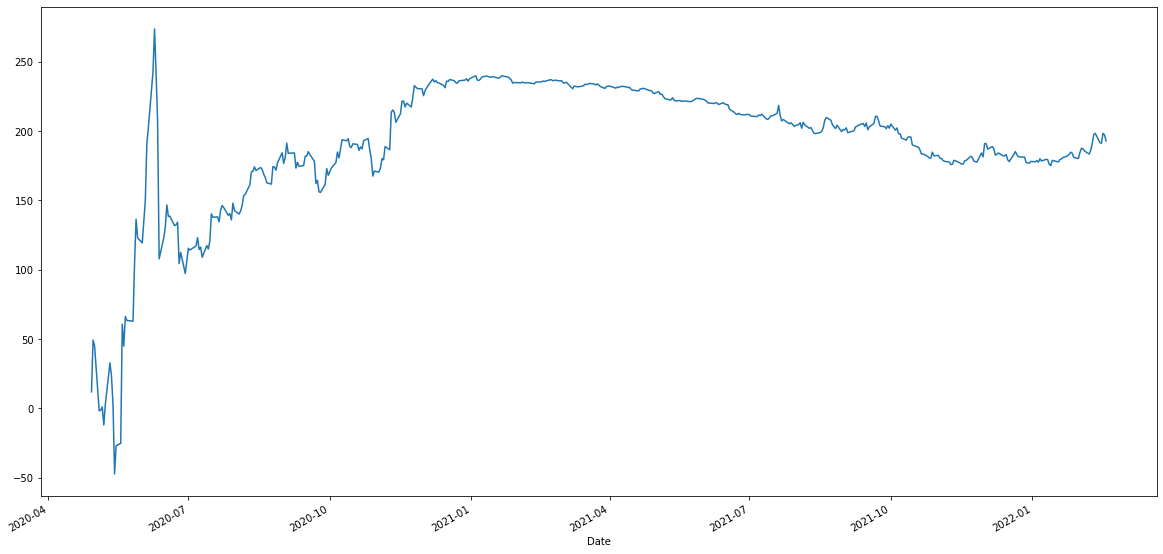

In [31]:
np.cumsum(df_pred_lr.sum(1)).plot(figsize=(20,10))

In [32]:
longs = []
shorts = []
for idx in range(df_pred_lr.shape[0]):
    vec = df_pred_lr.iloc[idx].values
    ord_ = np.argsort(vec)
    longs_day = df_lr.loc[df_pred_lr.index[idx]][df_pred_lr.columns[ord_[-5:]]]
    shorts_day = df_lr.loc[df_pred_lr.index[idx]][df_pred_lr.columns[ord_[:5]]]
    longs.append(longs_day)
    shorts.append(shorts_day)

# Cumulative histogram next-day log returns of top-10 predicted longs for every day.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   1.,   2.,   7.,   2.,  15.,  13.,  26.,  46.,  81., 138.,
        225., 362., 415., 332., 243., 136.,  98.,  57.,  26.,  14.,  14.,
          9.,   6.,  10.,   0.,   1.,   2.,   0.,   2.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.22202627, -0.21295638, -0.2038865 , -0.19481661, -0.18574673,
        -0.17667684, -0.16760696, -0.15853707, -0.14946719, -0.1403973 ,
        -0.13132742, -0.12225753, -0.11318764, -0.10411776, -0.09504787,
        -0.08597799, -0.0769081 , -0.06783822, -0.05876833, -0.04969845,
        -0.04062856, -0.03155868, -0.02248879, -0.01341891, -0.00434902,
         0.00472086,  0.01379075,  0.02286063,  0.03193052,  0.04100041,
         0.05007029,  0.05914018,  0.06821006,  0.07727995,  0.08634983,
         0.09541972,  0.1044896 ,  0.11355949,  0.12262937,  0.13169926,
         0.14076914,  0.14983903,  0.15890891,  0.1679788 ,  0.17704868,
 

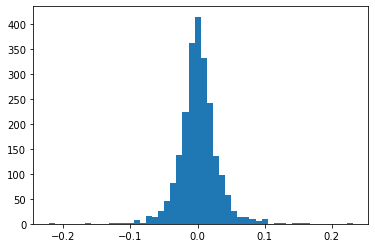

In [33]:
plt.hist(np.concatenate([el.values for el in longs]), bins=50)

# Cumulative histogram of top-10 shorts for every day.

(array([  2.,   0.,   0.,   0.,   1.,   2.,   3.,   5.,   5.,   5.,  12.,
         13.,  29.,  42.,  46., 110., 196., 291., 395., 409., 254., 179.,
        116.,  56.,  30.,  36.,  10.,  12.,   6.,   4.,   4.,   2.,   8.,
          0.,   2.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.16855079, -0.1595876 , -0.15062442, -0.14166123, -0.13269805,
        -0.12373486, -0.11477167, -0.10580849, -0.0968453 , -0.08788212,
        -0.07891893, -0.06995574, -0.06099256, -0.05202937, -0.04306619,
        -0.034103  , -0.02513981, -0.01617663, -0.00721344,  0.00174974,
         0.01071293,  0.01967612,  0.0286393 ,  0.03760249,  0.04656567,
         0.05552886,  0.06449205,  0.07345523,  0.08241842,  0.0913816 ,
         0.10034479,  0.10930798,  0.11827116,  0.12723435,  0.13619753,
         0.14516072,  0.15412391,  0.16308709,  0.17205028,  0.18101346,
         0.18997665,  0.19893983,  0.20790302,  0.21686621,  0.22582939,
 

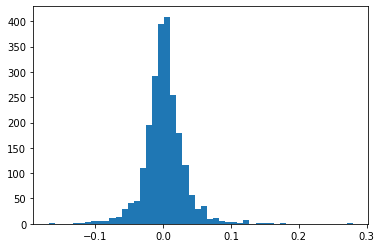

In [34]:
plt.hist(np.concatenate([el.values for el in shorts]), bins=50)

(array([ 1.,  0.,  0.,  0.,  2.,  1.,  0.,  3.,  2.,  8., 15., 42., 48.,
        62., 85., 82., 44., 22., 25.,  7.,  4.,  1.,  1.,  1.,  2.]),
 array([-0.05140949, -0.04780983, -0.04421017, -0.04061051, -0.03701085,
        -0.03341119, -0.02981154, -0.02621188, -0.02261222, -0.01901256,
        -0.0154129 , -0.01181324, -0.00821358, -0.00461393, -0.00101427,
         0.00258539,  0.00618505,  0.00978471,  0.01338437,  0.01698403,
         0.02058368,  0.02418334,  0.027783  ,  0.03138266,  0.03498232,
         0.03858198]),
 <BarContainer object of 25 artists>)

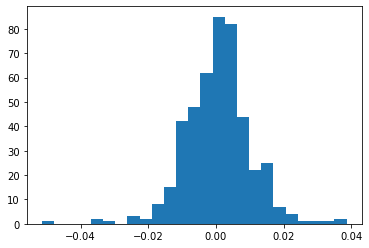

In [35]:
plt.hist([sum(1/10*el) for el in longs], bins=25)

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   4.,   8.,  23.,
         40.,  63., 103.,  90.,  58.,  38.,  11.,  10.,   2.,   2.,   1.,
          0.,   0.,   2.]),
 array([-0.06329195, -0.05865381, -0.05401567, -0.04937754, -0.0447394 ,
        -0.04010127, -0.03546313, -0.03082499, -0.02618686, -0.02154872,
        -0.01691059, -0.01227245, -0.00763431, -0.00299618,  0.00164196,
         0.0062801 ,  0.01091823,  0.01555637,  0.0201945 ,  0.02483264,
         0.02947078,  0.03410891,  0.03874705,  0.04338518,  0.04802332,
         0.05266146]),
 <BarContainer object of 25 artists>)

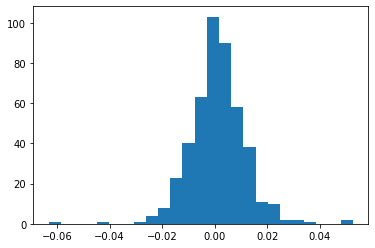

In [36]:
plt.hist([sum(1/10*el) for el in shorts], bins=25)

(array([59.,  0., 82.,  0., 83.,  0., 86.,  0., 97., 51.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

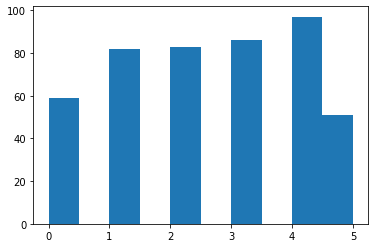

In [37]:
plt.hist([(el>0).sum() for el in longs])

(array([56.,  0., 75.,  0., 69.,  0., 97.,  0., 92., 69.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

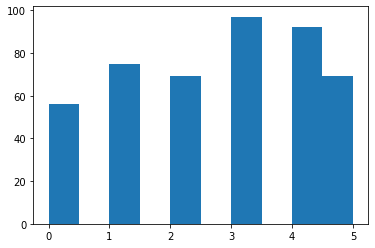

In [39]:
plt.hist([(el>0).sum() for el in shorts])